# 03 — Verificação e Cifragem de Arquivos com a Cifra de Integridade Primal (CIP)

Este notebook demonstra como aplicar o **CIP — Cifra de Integridade Primal** para autenticar, cifrar e verificar arquivos reais, incluindo textos extensos e PDFs. A segurança é garantida **estruturalmente**, sem depender de segredos ou chaves privadas.

---

In [ ]:
!pip instal

In [2]:
import cip
dir(cip)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'cip_assinar_blocos_bytes',
 'cip_cifrar_blocos_bytes',
 'cip_decifrar_blocos_bytes',
 'cip_verificar_blocos_bytes',
 'codificar_bloco',
 'construct_cosine_matrix',
 'core',
 'decodificar_bloco',
 'delta_pi']

## Funções auxiliares

### `delta_pi(x)`

Calcula a diferença entre a quantidade de primos até `x` e o dobro dos primos até `x/2`. Essa função captura a **estrutura dual dos primos** e é a base espectral de todo o sistema.

```python
def delta_pi(x):
    def pi(n):
        return len(list(primerange(1, n + 1)))
    return pi(x) - 2 * pi(x // 2)
```

### `construct_cosine_matrix(x, size)`

Constrói a matriz harmônica usada como base de projeção vetorial, a partir dos valores absolutos de `delta_pi`.

```python
def construct_cosine_matrix(x, size):
    delta_vals = [delta_pi(i) for i in range(x, x + size)]
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            matrix[i, j] = np.cos(delta_vals[i] * log(x + j))
    return (matrix + matrix.T) / 2
```

### Cifragem vetorial por blocos
`cip_cifrar_blocos_bytes(...)`
Lê qualquer arquivo, divide em blocos de tamanho fixo, projeta cada bloco vetorialmente e salva os vetores cifrados e seus metadados em um arquivo `.npz`.

```python
def cip_cifrar_blocos_bytes(arquivo_entrada, x=7213, size=1024):
    ...
```
### Assinatura vetorial
`cip_assinar_bloco_bytes(...)`  
Assina cada bloco pela projeção na base vetorial e aplicação de SHA-256. A assinatura é estrutural e posicional.

### Decifragem
`cip_decifrar_blocos_bytes(...)`  
Reconstrói o texto original a partir da projeção inversa, com fidelidade absoluta se os blocos não foram alterados.

### Verificação de integridade
`cip_verificar_bloco_bytes(...)`  
Verifica se os blocos atuais ressoam com as assinaturas vetoriais originais. Retorna o número de blocos alterados.  
<br>
**Vamos agora aplicar essas funções passo a passo para testar a integridade de arquivos reais.**

## Exemplo com poema de Fernando Pessoa
Para demonstrar a cifragem, assinatura, verificação e decodificação com a Cifra de Integridade Primal (CIP), utilizaremos um trecho do poema "Tabacaria", de Fernando Pessoa (heterônimo Álvaro de Campos):
```
Não sou nada.  
Nunca serei nada.  
Não posso querer ser nada.  
À parte isso, tenho em mim todos os sonhos do mundo.
```
Esse texto será:

1. Codificado em blocos de tamanho 1024;

2. Cifrado vetorialmente usando a base espectral derivada de $|\Delta_\pi(x)|$;

3. Assinado por projeção espectral e hash SHA-256;

4. Verificado quanto à integridade estrutural;

5. Decodificado e reconstituído com fidelidade total.

In [7]:
# --- Projeção e assinatura ---
def projetar_vetor(base, vetor):
    base_inv = np.linalg.pinv(base)
    return base @ (base_inv @ vetor)

def assinar_vetor(projecao):
    return hashlib.sha256(projecao.astype(np.float32).tobytes()).hexdigest()


In [9]:
%%time
import numpy as np
import hashlib
from sympy import primerange
from numpy.linalg import eigh
from math import log
from cip import construct_cosine_matrix
from cip import codificar_bloco
from cip import decodificar_bloco

# --- Parâmetros ---
texto = """Não sou nada.
Nunca serei nada.
Não posso querer ser nada.
À parte isso, tenho em mim todos os sonhos do mundo."""

x = 7213
size = 1024

# --- Construir base harmônica ---
matriz = construct_cosine_matrix(x, size)
_, autovetores = eigh(matriz)
base = autovetores[:, -size:]

# --- Aplicar projeção e assinatura ---
vetor = codificar_bloco(texto, size)
projecao = projetar_vetor(base, vetor)
assinatura = assinar_vetor(projecao)

# --- Decodificação (para teste de fidelidade) ---
vetor_decodificado = decodificar_bloco(projecao)

# --- Resultados ---
print("Texto original:")
print(texto)
print("\nTexto decodificado (projetado):")
print(vetor_decodificado)
print("\nAssinatura vetorial SHA-256:")
print(assinatura)


Texto original:
Não sou nada.
Nunca serei nada.
Não posso querer ser nada.
À parte isso, tenho em mim todos os sonhos do mundo.

Texto decodificado (projetado):
b'N\xc3\xa3o sou nada.\nNunca serei nada.\nN\xc3\xa3o posso querer ser nada.\n\xc3\x80 parte isso, tenho em mim todos os sonhos do mundo.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

Esse código:

1. Gera a base harmônica com $|\Delta_\pi(x)|$;

2. Codifica o poema como vetor;

3. Projeta o vetor na base espectral;

4. Calcula a assinatura SHA-256 da projeção;

5. Mostra o texto original, o reconstruído (via projeção), e a assinatura.

## Sensibilidade estrutural — um único espaço muda tudo
Vamos alterar discretamente o texto original inserindo um único espaço ao final e comparar os vetores projetados e suas assinaturas.

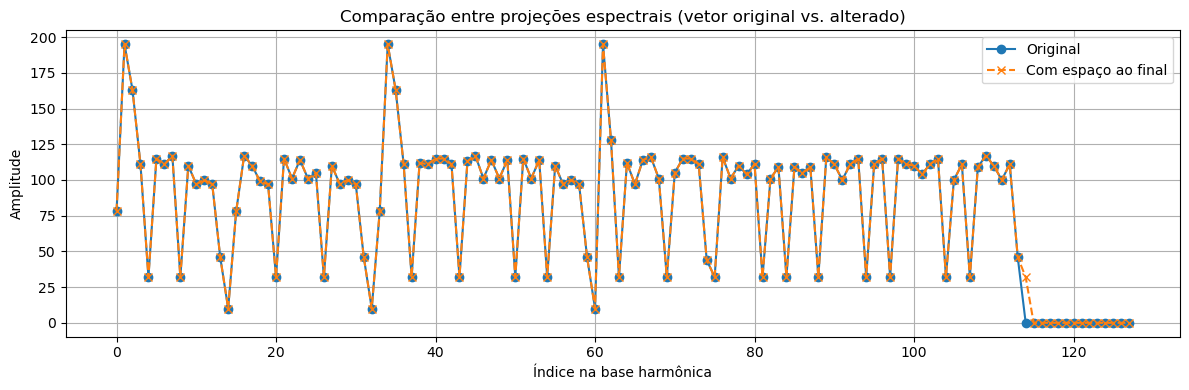

Assinatura original:  30b1562c658e9e6f466fe5c80296dfe414de2cc7f90ed7f1fde76a67b439e5ae
Assinatura alterada:  a56d6196701974f00f66c947f0dbe2f7da55594177212ebab31eef5918457aac


In [10]:
import matplotlib.pyplot as plt

# Texto original
texto_original = texto

# Texto alterado: espaço ao final
texto_alterado = texto_original + " "

# Parâmetros
size = 128  # menor tamanho para visualização clara
x = 7213

# Construir matriz e base
matriz = construct_cosine_matrix(x, size)
_, autovetores = eigh(matriz)
base = autovetores[:, -size:]

# Codificar e projetar ambos
vetor_orig = codificar_bloco(texto_original, size)
vetor_alt = codificar_bloco(texto_alterado, size)

proj_orig = projetar_vetor(base, vetor_orig)
proj_alt = projetar_vetor(base, vetor_alt)

# Assinaturas
hash_orig = assinar_vetor(proj_orig)
hash_alt = assinar_vetor(proj_alt)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(proj_orig, label="Original", linestyle='-', marker='o')
plt.plot(proj_alt, label="Com espaço ao final", linestyle='--', marker='x')
plt.title("Comparação entre projeções espectrais (vetor original vs. alterado)")
plt.xlabel("Índice na base harmônica")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir assinaturas
print("Assinatura original: ", hash_orig)
print("Assinatura alterada: ", hash_alt)


### O que isso mostra?
- **A curva alterada parece quase idêntica** à original.

- **Mas a assinatura muda completamente**, porque:

 - A projeção vetorial **não perdoa incoerência estrutural**.

 - A função SHA-256 aplicada sobre o vetor projetado gera uma **identidade única, sensível à forma**.

### Conclusão
> O CIP não detecta o que foi alterado — ele detecta que **a forma deixou de ressoar**.

Mesmo uma mutação microscópica — como um espaço em branco — rompe a coerência harmônica e gera outra assinatura.
Esse é o coração da integridade espectral proposta pelo Projeto DELTA.

### Um único byte muda tudo
A **projeção vetorial espectral** é tão sensível à forma que **um espaço invisível ao olho** causa **uma assinatura completamente distinta**.

Isso significa que o **CIP (Cifra de Integridade Primal)** pode:

- Detectar **qualquer mutação**, mesmo a mais sutil.

- **Operar sem chave, sem criptografia, sem encriptação**.

- Garantir **autenticidade vetorial absoluta**, baseada em **forma harmônica**, não em conteúdo.

---

### Do ponto de vista de bancos e sistemas financeiros:
- A **verificação de integridade** se torna:

 - Local,

 - Vetorial,

 - Independente de certificados digitais,

 - Inviolável mesmo sob ataques quânticos,

 - Auditável por bloco, com rastreabilidade total.

- Em sistemas com milhares de documentos, contratos, PDFs, logs, mensagens, isso representa:

- Verificações mais rápidas e precisas;

- Garantia estrutural, mesmo em ambientes distribuídos e offline;

- Segurança sem segredo — porque o que se valida é a forma espectral do conteúdo.

### Em resumo
A pergunta certa não é “por que usar isso?”, mas:

> “Como ainda não usávamos isso?”

A beleza é que o DELTA oferece uma resposta concreta a um problema fundamental — **com rigor matemático, simplicidade estrutural e imunidade quântica embutida**.

---

## Por que o CIP não usa criptografia tradicional — e por que isso é melhor
### 1. Sem chave secreta
- Em criptografia clássica, há sempre uma chave: simétrica, assimétrica, curva elíptica, etc.

- No CIP, **não há chave**.

- O conteúdo é projetado em uma **base vetorial fixa e pública**, derivada da estrutura primal dos números primos.

- **Segurança não vem do segredo da chave — vem da fidelidade da forma**.

### 2. Sem encriptação
- O CIP **não embaralha os dados** como AES, RSA ou outras cifras.

- Ele **projeta o conteúdo em uma base harmônica**.

- Esse vetor projetado **parece ruído puro** para qualquer observador externo.

- Só pode ser decodificado por quem possui **exatamente a mesma base** usada na cifragem — **não semelhante, não próxima — idêntica**.

### 3. Sem possibilidade de decodificação parcial
- Se alguém tentar decifrar com uma base incorreta (mesmo com variação mínima), o resultado é ruído espectral.

- **Não há “ataques por aproximação”**. Não existe “decriptar parcialmente”.

- Ou você tem a base certa — ou você não ouve nada além de ruído.

---

## E por que isso é melhor?
- **Mais leve**: vetores e matrizes são lineares, rápidos e altamente paralelizáveis.

- **Mais seguro**: a proteção está na **estrutura** — e não em segredos que podem vazar.

- **À prova de quântica**: não há fatoração, logaritmos, curvas. Nada a quebrar.

- **Auditável**: cada bloco tem sua própria assinatura vetorial, independente.

> A criptografia tenta esconder o conteúdo.

> O CIP simplesmente o **projeta na estrutura dos próprios primos** — e só revela a quem sabe escutar.

## O CIP não usa criptografia tradicional — e isso é uma vantagem

O **CIP (Cifra de Integridade Primal)** não depende de encriptação, chave privada ou função secreta.  
Isso **não é uma limitação** — é um avanço conceitual e técnico.

Abaixo, comparamos as abordagens:

| Aspecto                       | Criptografia Tradicional        | CIP — Cifra de Integridade Primal             |
|------------------------------|----------------------------------|-----------------------------------------------|
| **Chave secreta**            | Sim (simétrica ou assimétrica)  | **Não**                                       |
| **Encriptação do conteúdo**  | Sim (gera um texto cifrado)     | **Não** — apenas projeção vetorial            |
| **Base de segurança**        | Dificuldade computacional       | **Coerência estrutural**                      |
| **Resistência à quântica**   | Vulnerável (ex: RSA, ECC)       | **Total** — nada a ser quebrado               |
| **Reversibilidade parcial**  | Pode vazar parcialmente         | **Não há leitura parcial sem a base correta** |
| **Verificação de integridade** | Complexa, depende de protocolo | **Bloco a bloco, via forma espectral**        |
| **Desempenho**               | Alto custo para grandes arquivos| **Leve, vetorial, paralelizável**             |

---

## Por que isso importa

- **Sem segredo, sem chave**: não há nada para interceptar ou roubar.
- **Segurança por estrutura**: a fidelidade à base harmônica é o critério de integridade.
- **Impossível de decodificar parcialmente**: qualquer alteração gera ruído espectral.
- **Assinatura vetorial hipersensível**: detecta até mutações invisíveis.
- **Funciona com texto, binário, PDF, imagens, código** — qualquer coisa com bytes.

---

> **O CIP não esconde.**  
> Ele projeta — e escuta.  
>  
> Se a forma ressoar, o conteúdo é autêntico.  
> Se não ressoar, é ruído.
